In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIRimport os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
# %cd /content/drive/MyDrive/Kaggle
# !kaggle datasets download -d lexset/synthetic-asl-alphabet #

In [ ]:
# !unzip \*.zip # unzipping the datasets

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

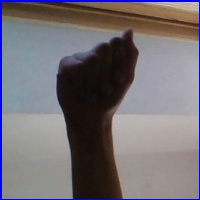

In [ ]:
from PIL import Image

model_builder = keras.applications.xception.Xception
img_size = (48, 48)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block5_conv4"

# The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
# )
img_path = '/content/drive/MyDrive/Kaggle/asl_alphabet_train/asl_alphabet_train/A/A1.jpg'

display(Image.open(img_path))

In [ ]:
from tensorflow.keras.models import load_model
import keras.applications
# Load the model
model = load_model('/content/drive/MyDrive/my_model (1).h5')

In [ ]:

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer -- let's say we have 7 classes
# predictions = Dense(7, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 2s 2s/step
Predicted class index: 7
Predicted class label: Z


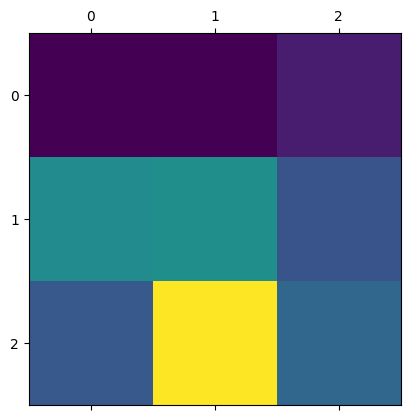

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

preds = model.predict(img_array)
# Print the predicted class index
predicted_class_index = np.argmax(preds)
print("Predicted class index:", predicted_class_index)

# Define your custom class labels
class_labels = ['I','O','V','C','X','S','W','Z','T','H','K','Blank','E','F','Q','U','G','A','Y','N','L','J','D','M','R','P','B']
# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted class label:", predicted_class_label)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

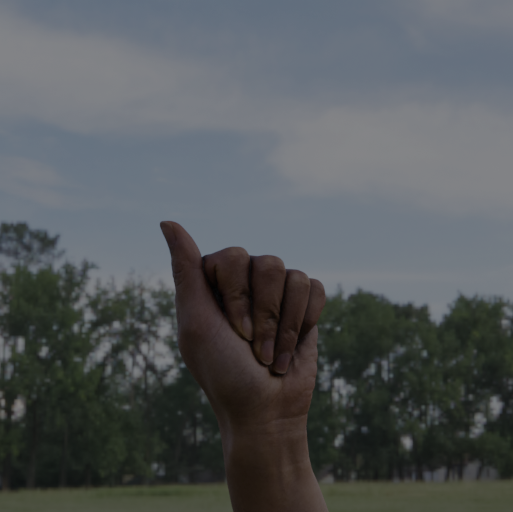

In [ ]:
import numpy as np
from PIL import Image

# Function to save and display Grad CAM
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = Image.open(img_path)

    # Convert images to numpy arrays
    img_array = np.array(img)
    heatmap_array = np.array(heatmap)

    # Resize heatmap to match the dimensions of the original image
    heatmap_resized = np.array(Image.fromarray(heatmap_array).resize(img.size))

    # Apply alpha blending to combine the heatmap and original image
    superimposed_img_array = (heatmap_resized * alpha)[:, :, np.newaxis] + (img_array * (1 - alpha))

    # Convert the numpy array back to PIL Image
    superimposed_img = Image.fromarray(superimposed_img_array.astype('uint8'))

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(superimposed_img)

# Call the function to save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)


In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2

os.environ["KERAS_BACKEND"] = "tensorflow"

# Function to load and preprocess an image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to generate Grad CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to save and display Grad CAM
def save_and_display_gradcam(img_path, heatmap, label, cam_path="cam.jpg", alpha=0.4):
    img = Image.open(img_path)

    heatmap = np.array(heatmap)
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

    heatmap_normalized = heatmap / np.max(heatmap) * 255
    heatmap_colormap = cv2.applyColorMap(np.uint8(heatmap_normalized), cv2.COLORMAP_INFERNO)
    heatmap_pil = Image.fromarray(heatmap_colormap)

    img_rgb = img.convert("RGB")
    superimposed_img = Image.blend(img_rgb, heatmap_pil.convert('RGB'), alpha=alpha)

    # Add label with black background
    draw = ImageDraw.Draw(superimposed_img)
    font_size = 70
    font = ImageFont.load_default()  # Use default font
    label_width, label_height = draw.textsize(label, font=font)
    background_box = (10, 10, 10 + label_width, 10 + label_height)
    draw.rectangle(background_box, fill="black")
    draw.text((10, 10), label, fill="white", font=font)

    superimposed_img.save(cam_path)
    display(superimposed_img)


# Define model, last_conv_layer_name, and other parameters
model = load_model('/content/drive/MyDrive/my_model (1).h5')
last_conv_layer_name = "block5_conv4"
img_size = (48, 48)
preprocess_input = keras.applications.xception.preprocess_input

# List of image paths and their respective labels
image_paths = ['/content/drive/MyDrive/Kaggle3/Test_Alphabet/A/081a8b28-7394-4254-95aa-e40f7c8989c8.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/B/000c25e4-9115-4410-9415-d4d0a2a2060a.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Blank/003c6b4c-71b0-444e-b323-ae4f1bbe167d.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/C/0062008e-af72-4656-affe-91024e2a26ba.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/D/00695f74-9733-4fc2-8834-3b85dac2631f.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/E/00389b53-9a04-4467-81f5-ebe59919246c.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/F/00171973-b657-4eb1-b4f6-5a83e61172db.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/G/00142e4c-144e-4fb5-9427-5893d034f18f.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/H/002022a6-7e33-47a6-8116-980492947340.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/I/0017c08d-fb07-471f-a71f-bac67c757c3a.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/J/00ae00b9-8c76-4e28-8ae9-39bbf043a756.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/K/003b74ce-132b-43ac-b8fe-fbc06ccfdb30.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/L/004fd1b4-8e7d-476f-ac72-b10bf61d1923.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/M/01982323-48f0-48f7-afb0-c7ca3b7dbff0.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/N/0076bf88-179f-4319-9e8d-00b55675b4c2.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/O/00036d50-94a3-4db2-932c-b951305f521d.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/P/00369fd3-7d60-4a58-991d-08a0cc8504cd.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Q/0005464e-3e97-47c4-a5e9-7c7dffac31b6.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/R/001ff4dd-b85e-48fb-8242-3c6ba27f05a6.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/S/00a77c28-0362-42d8-832c-769186f9a1a9.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/T/003fd151-4369-4107-900e-d80e3d06bda4.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/U/001dc3f6-010f-4ecc-a94b-761d2855ffad.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/V/00148b8e-fcc6-4d65-a25b-41c63d749ac0.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/W/00040651-df9e-4270-88ea-6a3344cba82d.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/X/002354da-ffdf-4cde-a790-5395164996bb.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Y/0065d017-b851-445c-be11-e077523440cf.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Z/001f320c-eaa5-413c-92c6-0534ba0ea766.rgb_0000.png',

               ]
labels = ['A', 'B','Blank','C','D','E','F','G','H','I','J','K','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# Generate Grad CAM for each image
for img_path, label in zip(image_paths, labels):
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap, label, cam_path=f"cam_{label}.jpg")


Output hidden; open in https://colab.research.google.com to view.

SCORECAM

In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2

os.environ["KERAS_BACKEND"] = "tensorflow"

# Function to load and preprocess an image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to generate Score-CAM heatmap
def make_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_mean(last_conv_layer_output, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to save and display Score-CAM
def save_and_display_scorecam(img_path, heatmap, label, cam_path="cam.jpg", alpha=0.4):
    img = Image.open(img_path)

    heatmap = np.array(heatmap)
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

    heatmap_normalized = heatmap / np.max(heatmap) * 255
    heatmap_colormap = cv2.applyColorMap(np.uint8(heatmap_normalized), cv2.COLORMAP_INFERNO)
    heatmap_pil = Image.fromarray(heatmap_colormap)

    img_rgb = img.convert("RGB")
    superimposed_img = Image.blend(img_rgb, heatmap_pil.convert('RGB'), alpha=alpha)

    # Add label with black background
    draw = ImageDraw.Draw(superimposed_img)
    font_size = 70
    font = ImageFont.load_default()  # Use default font
    label_width, label_height = draw.textsize(label, font=font)
    background_box = (10, 10, 10 + label_width, 10 + label_height)
    draw.rectangle(background_box, fill="black")
    draw.text((10, 10), label, fill="white", font=font)

    superimposed_img.save(cam_path)
    display(superimposed_img)

# Define model, last_conv_layer_name, and other parameters
model = load_model('/content/drive/MyDrive/my_model (1).h5')
last_conv_layer_name = "block5_conv4"
img_size = (48, 48)
preprocess_input = keras.applications.xception.preprocess_input

# List of image paths and their respective labels
# List of image paths and their respective labels
image_paths = ['/content/drive/MyDrive/Kaggle3/Test_Alphabet/A/081a8b28-7394-4254-95aa-e40f7c8989c8.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/B/000c25e4-9115-4410-9415-d4d0a2a2060a.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Blank/003c6b4c-71b0-444e-b323-ae4f1bbe167d.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/C/0062008e-af72-4656-affe-91024e2a26ba.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/D/00695f74-9733-4fc2-8834-3b85dac2631f.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/E/00389b53-9a04-4467-81f5-ebe59919246c.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/F/00171973-b657-4eb1-b4f6-5a83e61172db.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/G/00142e4c-144e-4fb5-9427-5893d034f18f.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/H/002022a6-7e33-47a6-8116-980492947340.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/I/0017c08d-fb07-471f-a71f-bac67c757c3a.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/J/00ae00b9-8c76-4e28-8ae9-39bbf043a756.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/K/003b74ce-132b-43ac-b8fe-fbc06ccfdb30.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/L/004fd1b4-8e7d-476f-ac72-b10bf61d1923.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/M/01982323-48f0-48f7-afb0-c7ca3b7dbff0.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/N/0076bf88-179f-4319-9e8d-00b55675b4c2.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/O/00036d50-94a3-4db2-932c-b951305f521d.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/P/00369fd3-7d60-4a58-991d-08a0cc8504cd.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Q/0005464e-3e97-47c4-a5e9-7c7dffac31b6.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/R/001ff4dd-b85e-48fb-8242-3c6ba27f05a6.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/S/00a77c28-0362-42d8-832c-769186f9a1a9.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/T/003fd151-4369-4107-900e-d80e3d06bda4.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/U/001dc3f6-010f-4ecc-a94b-761d2855ffad.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/V/00148b8e-fcc6-4d65-a25b-41c63d749ac0.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/W/00040651-df9e-4270-88ea-6a3344cba82d.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/X/002354da-ffdf-4cde-a790-5395164996bb.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Y/0065d017-b851-445c-be11-e077523440cf.rgb_0000.png',
               '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Z/001f320c-eaa5-413c-92c6-0534ba0ea766.rgb_0000.png',

               ]
labels = ['A', 'B','Blank','C','D','E','F','G','H','I','J','K','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
# Generate Score-CAM for each image
for img_path, label in zip(image_paths, labels):
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_scorecam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_scorecam(img_path, heatmap, label, cam_path=f"cam_{label}.jpg")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "tensorflow"

# Function to load and preprocess an image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to generate HiResCAM heatmap
def make_hirescam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Reshape the gradients to match the shape of the last convolutional layer output
    last_conv_layer_output = last_conv_layer_output[0]
    grads = tf.reshape(grads, last_conv_layer_output.shape)

    pooled_grads = grads
    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to generate Score-CAM heatmap
def make_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_mean(last_conv_layer_output, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to generate Grad CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to generate EigenGradCAM heatmap
def make_eigengradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]

    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    eigen_gradcam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)

    eigen_gradcam = np.maximum(eigen_gradcam, 0)
    eigen_gradcam /= np.max(eigen_gradcam)

    return eigen_gradcam

# Define model, last_conv_layer_name, and other parameters
model = load_model('/content/drive/MyDrive/my_model (1).h5')
last_conv_layer_name = "block5_conv4"
img_size = (48, 48)
preprocess_input = tf.keras.applications.xception.preprocess_input

# List of image paths and their respective labels
image_paths = [
    '/content/drive/MyDrive/Kaggle3/Test_Alphabet/A/081a8b28-7394-4254-95aa-e40f7c8989c8.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/B/000c25e4-9115-4410-9415-d4d0a2a2060a.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/Blank/003c6b4c-71b0-444e-b323-ae4f1bbe167d.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/C/0062008e-af72-4656-affe-91024e2a26ba.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/D/00695f74-9733-4fc2-8834-3b85dac2631f.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/E/00389b53-9a04-4467-81f5-ebe59919246c.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/F/00171973-b657-4eb1-b4f6-5a83e61172db.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/G/00142e4c-144e-4fb5-9427-5893d034f18f.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/H/002022a6-7e33-47a6-8116-980492947340.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/I/0017c08d-fb07-471f-a71f-bac67c757c3a.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/J/00ae00b9-8c76-4e28-8ae9-39bbf043a756.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/K/003b74ce-132b-43ac-b8fe-fbc06ccfdb30.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/L/004fd1b4-8e7d-476f-ac72-b10bf61d1923.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/M/01982323-48f0-48f7-afb0-c7ca3b7dbff0.rgb_0000.png',
    '/content/drive/MyDrive/Kaggle3/Train_Alphabet/N/0076bf88-179f-4319-9e8d-00b55675b4c2.rgb_0000.png'
]

labels = [
    'Label A', 'Label B', 'Label Blank', 'Label C', 'Label D', 'Label E', 'Label F', 'Label G', 'Label H', 'Label I',
    'Label J', 'Label K', 'Label L', 'Label M', 'Label N'
]

# Function to display side-by-side comparison of heatmaps
def display_heatmap_comparison(img_path, heatmap1, heatmap2, heatmap3, heatmap4, label):
    img = Image.open(img_path)

    # Resize heatmaps to match image size
    heatmap1 = cv2.resize(heatmap1, (img.size[0], img.size[1]))
    heatmap2 = cv2.resize(heatmap2, (img.size[0], img.size[1]))
    heatmap3 = cv2.resize(heatmap3, (img.size[0], img.size[1]))
    heatmap4 = cv2.resize(heatmap4, (img.size[0], img.size[1]))

    # Apply colormap to heatmaps
    heatmap_colormap1 = cv2.applyColorMap(np.uint8(heatmap1 * 255), cv2.COLORMAP_JET)
    heatmap_colormap2 = cv2.applyColorMap(np.uint8(heatmap2 * 255), cv2.COLORMAP_JET)
    heatmap_colormap3 = cv2.applyColorMap(np.uint8(heatmap3 * 255), cv2.COLORMAP_JET)
    heatmap_colormap4 = cv2.applyColorMap(np.uint8(heatmap4 * 255), cv2.COLORMAP_JET)

    # Blend heatmaps with original image
    superimposed_img1 = cv2.addWeighted(np.array(img), 0.6, heatmap_colormap1, 0.4, 0)
    superimposed_img2 = cv2.addWeighted(np.array(img), 0.6, heatmap_colormap2, 0.4, 0)
    superimposed_img3 = cv2.addWeighted(np.array(img), 0.6, heatmap_colormap3, 0.4, 0)
    superimposed_img4 = cv2.addWeighted(np.array(img), 0.6, heatmap_colormap4, 0.4, 0)

    # Add label to the image
    def add_label(img, label):
        pil_img = Image.fromarray(img)
        draw = ImageDraw.Draw(pil_img)
        font = ImageFont.load_default()
        text_bbox = draw.textbbox((0, 0), label, font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        draw.rectangle(((0, 0), (text_width + 10, text_height + 10)), fill="black")
        draw.text((5, 5), label, fill="white", font=font)
        return np.array(pil_img)

    superimposed_img1 = add_label(superimposed_img1, label)
    superimposed_img2 = add_label(superimposed_img2, label)
    superimposed_img3 = add_label(superimposed_img3, label)
    superimposed_img4 = add_label(superimposed_img4, label)

    # Display side-by-side comparison
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(superimposed_img1)
    axes[0].set_title('HiResCAM')
    axes[0].axis('off')
    axes[1].imshow(superimposed_img2)
    axes[1].set_title('Score-CAM')
    axes[1].axis('off')
    axes[2].imshow(superimposed_img3)
    axes[2].set_title('Grad-CAM')
    axes[2].axis('off')
    axes[3].imshow(superimposed_img4)
    axes[3].set_title('EigenGradCAM')
    axes[3].axis('off')
    plt.show()

# Generate heatmaps and compare
for img_path, label in zip(image_paths, labels):
    img_array = get_img_array(img_path, size=img_size)

    # Generate heatmaps using different methods
    hirescam_heatmap = make_hirescam_heatmap(img_array, model, last_conv_layer_name)
    scorecam_heatmap = make_scorecam_heatmap(img_array, model, last_conv_layer_name)
    gradcam_heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    eigengradcam_heatmap = make_eigengradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display comparison
    display_heatmap_comparison(img_path,
                                hirescam_heatmap,
                                scorecam_heatmap,
                                gradcam_heatmap,
                                eigengradcam_heatmap,
                                label)


Output hidden; open in https://colab.research.google.com to view.

SHAP

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
import tensorflow as tf
# model = tf.keras.models.load_model('/content/drive/MyDrive/detect2.keras')

In [ ]:
model = load_model('/content/drive/MyDrive/my_model (1).h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG19
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications.vgg19 import preprocess_input


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/MyDrive/Kaggle3/Train_Alphabet/'
test_data_dir = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/'

# Initialize ImageDataGenerator for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48, 48),
        batch_size=32,
        class_mode='categorical')

# Flow validation images in batches of 32 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(48, 48),
        batch_size=32,
        class_mode='categorical')

# Now you can use train_generator and test_generator for training and testing your model


Found 24301 images belonging to 27 classes.
Found 2700 images belonging to 27 classes.


In [ ]:

# Convert batches of data to NumPy arrays
num_batches = len(train_generator)
data_array = []
labels_array = []

for i in range(5):
    batch_data, batch_labels = next(train_generator)
    data_array.append(batch_data)
    labels_array.append(batch_labels)

# Concatenate the batches into a single NumPy array
data_array = np.concatenate(data_array)
labels_array = np.concatenate(labels_array)

In [ ]:
background = data_array[np.random.choice(data_array.shape[0], 100, replace=False)]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

# Compute shap values
# shap_values = e.shap_values(x_test[1:5])


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [ ]:
shap_values = e.shap_values(data_array[1:5])

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


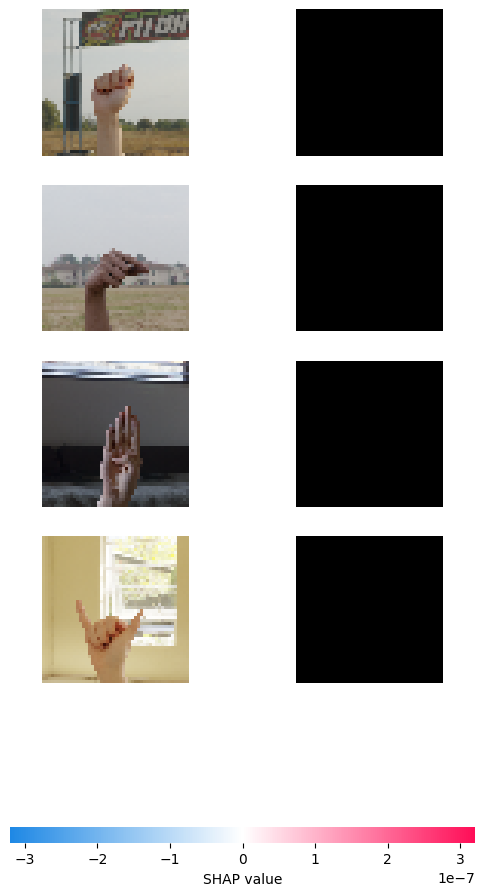

In [ ]:
# plot the feature attributions
shap.image_plot(shap_values, data_array[1:5])

In [ ]:

# Define the ImageMasker with the appropriate image shape
masker = shap.maskers.Image(shape=(48, 48, 3), mask_value=0)

#

def f(X):
    tmp = X.copy()
    return model(tmp)




output_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# Create the explainer with the ImageMasker
explainer = shap.Explainer(f, masker, output_names=output_names)



shap_values = explainer(
    test_data_array[1:10], max_evals=100, batch_size=32, outputs=shap.Explanation.argsort.flip[:1]
)
shap.image_plot(shap_values)

NameError: name 'test_data_array' is not defined

LIME

In [ ]:
!pip install lime

In [ ]:
import os
import tensorflow as tf
import numpy as np
import PIL
from keras.applications.imagenet_utils import decode_predictions
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
!pip list | grep scikit-image

scikit-image                     0.19.3


In [ ]:
!pip install --upgrade scikit-image

In [ ]:
inet_model = load_model('/content/drive/MyDrive/my_model (1).h5')

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 48, 48, 3), found shape=(None, 299, 299, 3)


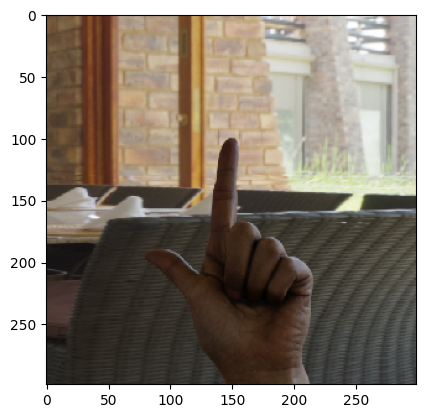

In [ ]:
images = transform_img_fn([os.path.join('/content/drive/MyDrive/Kaggle3/Train_Alphabet/L/','004fd1b4-8e7d-476f-ac72-b10bf61d1923.rgb_0000.png')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=31316b3aa27a4d8db0e8aae408fe3fc639394840177a9b66b0f50a56c75aacad
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 48, 48, 3), found shape=(None, 299, 299, 3)


In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

NameError: name 'explanation' is not defined

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[1]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()